In [2]:
!pip install -U -q datasets==2.15 evaluate accelerate

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
cudf 23.8.0 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.4.0 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.1.4 which is incompatible.
cudf

In [3]:
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
from huggingface_hub import notebook_login
notebook_login()

In [4]:
data = pd.read_csv('/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv')

In [5]:
def labelling(rating):
    if rating < 3: return 'negative'
    if rating < 4: return 'neutral'
    return 'positive'
data['label'] = data['Rating'].apply(labelling)

In [6]:
data['label'].value_counts()

label
positive    15093
negative     3214
neutral      2184
Name: count, dtype: int64

In [7]:
import emoji
import re

def text_cleaning(text):
    text = emoji.demojize(text)
    text = re.sub('n\'t', 'not', text)
    return text
data['Review'] = data['Review'].apply(text_cleaning)
data = data.drop(['Rating'], axis=1)

In [8]:
from collections import Counter
most_word=" ".join(data["Review"].values).split()
word_counts=Counter(most_word)
word_counts.most_common()
most_common_words_list = [{'word': word, 'count': count} for word, count in word_counts.items()]

most_words_df=pd.DataFrame(data=most_common_words_list,columns=["word","count"])
most_words_df.head()

,word,count
0,nice,10918
1,hotel,42079
2,expensive,1551
3,parking,1470
4,got,5951


In [ ]:
# visualize the frequency of top 20 most common words
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.title('Top 20 most common words')
sns.barplot(data=most_words_df[:20].sort_values(by="count",ascending=False) ,y="word",x="count",palette="viridis")
plt.show()

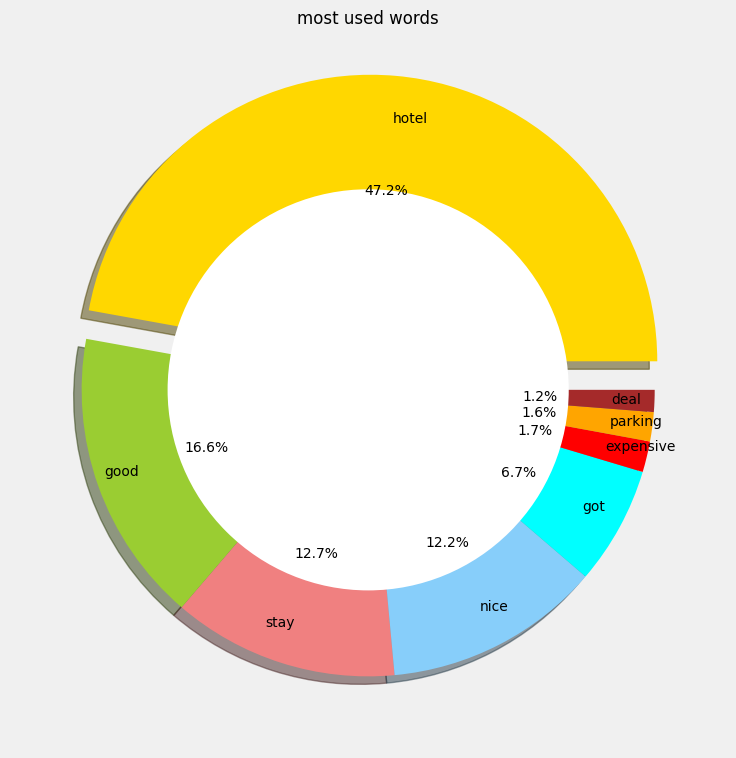

In [9]:
labels=most_words_df[:8].sort_values(by="count",ascending=False)["word"].values
sizes=most_words_df[:8].sort_values(by="count",ascending=False)["count"].values
explode = (0.1, 0, 0, 0, 0, 0, 0, 0)
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue',"cyan","red","orange","brown"]

plt.figure(figsize=(15,15))
plt.subplot(2,1,2)

plt.pie(sizes,explode=explode,labels=labels,colors=colors,autopct='%1.1f%%', shadow=True,textprops={'fontsize': 10},labeldistance=0.85, startangle=0)
plt.title("most used words")
plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white'))

plt.gcf().set_facecolor('#f0f0f0')

plt.tight_layout()
plt.show()

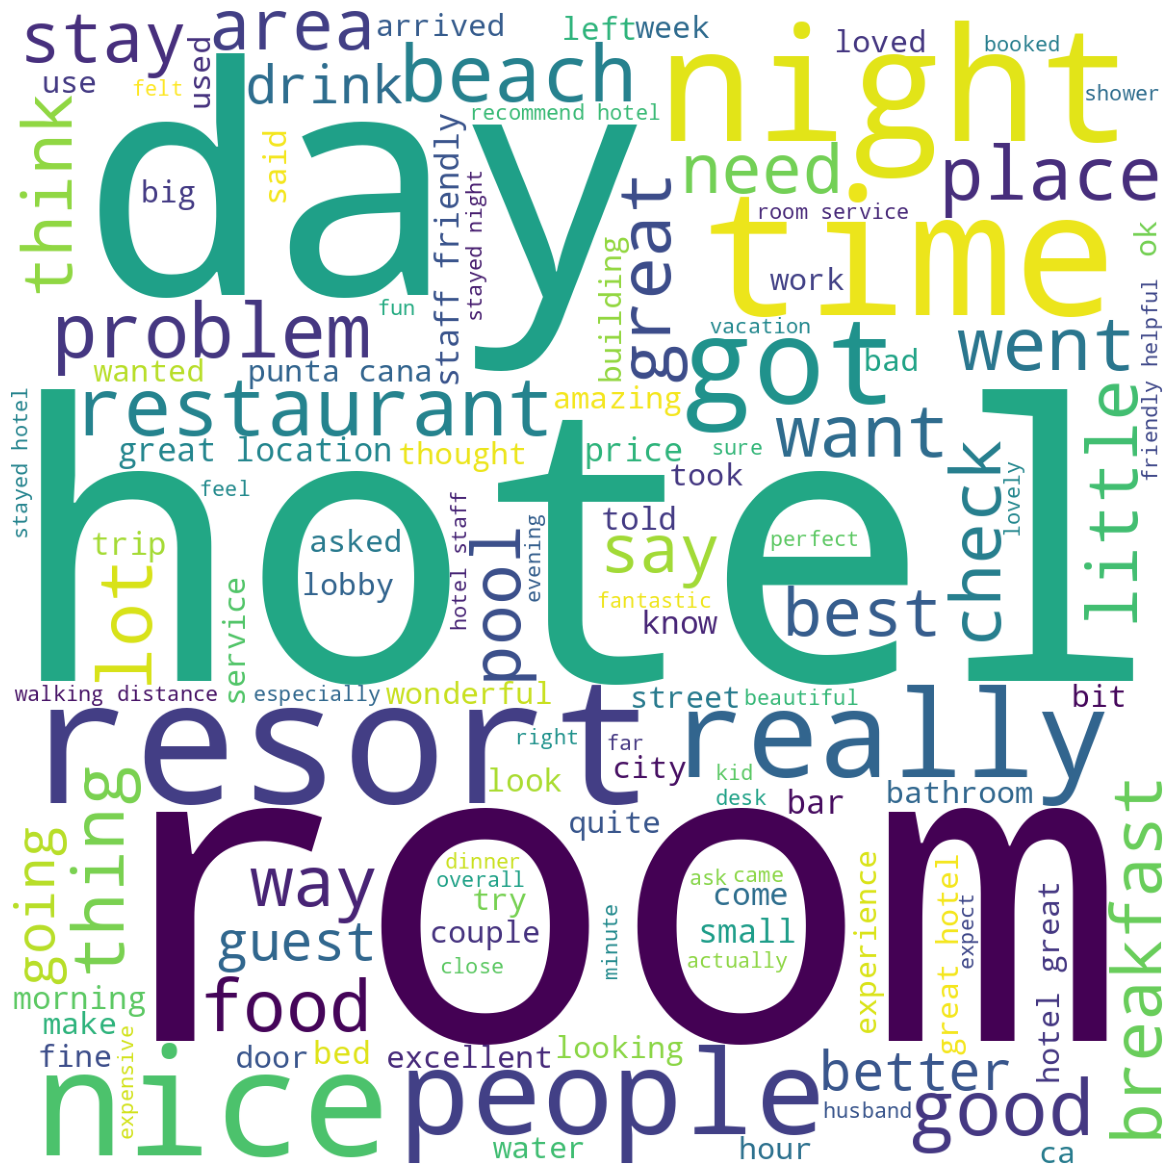

In [10]:
from wordcloud import WordCloud


text=str(list(data["Review"]))
plt.rcParams['figure.figsize'] = (15, 15)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 121).generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_valid_test, y_train, y_valid_test = train_test_split(data.loc[:, data.columns!='label'],
                                                                data['label'],
                                                                test_size=0.2,
                                                                stratify=data['label'])
X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test,
                                                    y_valid_test,
                                                    test_size=0.5,
                                                    stratify=y_valid_test)

In [10]:
data_train = pd.DataFrame([X_train['Review'], y_train]).T
data_test = pd.DataFrame([X_test['Review'], y_test]).T
data_valid = pd.DataFrame([X_valid['Review'], y_valid]).T

In [11]:
from datasets import DatasetDict, Dataset
dts = DatasetDict()
dts['train'] = Dataset.from_pandas(data_train)
dts['test'] = Dataset.from_pandas(data_test)
dts['valid'] = Dataset.from_pandas(data_valid)

In [12]:
label2id = {'negative': 0, 'neutral': 1, 'positive': 2}
id2label = {value: key for key, value in label2id.items()}

In [13]:
import torch
if torch.cuda.is_available():
    device = 'cuda'
else: device = 'cpu'

In [14]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model_ckpt ='google-bert/bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                          id2label=id2label,
                                                          label2id=label2id,
                                                          num_labels=3).to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
def tokenize(examples):
    tokens = tokenizer(examples['Review'],
                       max_length=512,
                       truncation=True
                      )
    examples['label'] = [label2id[l] for l in examples['label']]
    return tokens

dts = dts.map(tokenize, batched=True, batch_size=64)

Map:   0%|          | 0/16392 [00:00<?, ? examples/s]

Map:   0%|          | 0/2050 [00:00<?, ? examples/s]

Map:   0%|          | 0/2049 [00:00<?, ? examples/s]

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_metrics(eval_pred):
    predictions, labels = np.array(eval_pred.predictions).argmax(-1), eval_pred.label_ids
    return {'precision': precision_score(labels, predictions, average='weighted'),
            'recall': recall_score(labels, predictions, average='weighted'),
            'f1': f1_score(labels, predictions, average='weighted')}

In [17]:
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
training_arguments = TrainingArguments(output_dir='sentiment-bert-base-uncased',
                                       do_eval=True,
                                       num_train_epochs=3,
                                       evaluation_strategy='epoch',
                                       per_device_train_batch_size=16,
                                       per_device_eval_batch_size=16,
                                       learning_rate=2e-5,
                                       lr_scheduler_type='cosine',
                                       warmup_ratio=0.1,
                                       logging_strategy='steps',
                                       logging_steps=10,
                                       save_strategy='epoch',
                                       metric_for_best_model='recall',
                                       gradient_accumulation_steps=2,
                                       fp16=True,
                                       report_to='wandb'
                                       push_to_hub=True
                                       )

2024-04-10 05:44:46.773587: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 05:44:46.773696: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 05:44:47.063578: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [18]:
trainer = Trainer(model=model,
                  args=training_arguments,
                  train_dataset=dts['train'],
                  eval_dataset=dts['valid'],
                  compute_metrics=compute_metrics,
                  data_collator=data_collator
                 )
trainer.train()

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
0,0.282000,0.384248,0.857295,0.869204,0.859356
2,0.200400,0.326022,0.876230,0.875061,0.875499


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=768, training_loss=0.31879396302004653, metrics={'train_runtime': 2302.1401, 'train_samples_per_second': 21.361, 'train_steps_per_second': 0.334, 'total_flos': 1.1340961199741376e+16, 'train_loss': 0.31879396302004653, 'epoch': 2.99})

In [ ]:
trainer.push_to_hub()

In [73]:
torch.cuda.empty_cache()

### Model checking


In [55]:
from transformers import AutoModel
check_model = AutoModelForSequenceClassification.from_pretrained('1-13-am/sentiment-bert-based-uncased')

In [56]:
text = ['Everything about this hotel is amazing. I will definitely come back!']
tokens = tokenizer(text)

In [59]:
out = check_model(input_ids=torch.LongTensor(tokens['input_ids']), 
                  attention_mask=torch.LongTensor(tokens['attention_mask']))

In [73]:
predict = check_model.config.id2label[out.logits.argmax(-1).item()]

In [74]:
predict

'positive'